In [5]:
# Core
import torch
import torch.nn as nn
import torch.optim as optim

# Data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Utils
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Part 0 – Data Preparation

In this step we:
- Load the dataset using ImageFolder
- Split into training and validation sets (80/20)
- Apply data augmentations to the training set
- Create PyTorch DataLoaders


In [6]:
# ---------------------------------------------
# STEP 1: Import required libraries (PyTorch + Torchvision)
# ---------------------------------------------
from pathlib import Path

import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

# ---------------------------------------------
# STEP 2: Define dataset path
# ---------------------------------------------
data_path = Path.cwd().parent.parent / "data"
assert data_path.exists(), f"Data path not found: {data_path}"

# ---------------------------------------------
# STEP 3: Define image size and transforms
# Train transforms include augmentation to improve generalization.
# Validation transforms are deterministic for consistent evaluation.
# ---------------------------------------------
img_size = 224

train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),      # Resize all images to a fixed size
    transforms.RandomHorizontalFlip(p=0.5),       # Randomly flip images (augmentation)
    transforms.RandomRotation(10),                # Randomly rotate by up to 10 degrees (augmentation)
    transforms.ToTensor(),                        # Convert PIL image -> PyTorch Tensor (C, H, W), values [0..1]
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),      # Resize (same as train)
    transforms.ToTensor(),                        # Convert to tensor (no randomness here)
])

# ---------------------------------------------
# STEP 4: Create a base dataset using ImageFolder
# ---------------------------------------------
base_ds = datasets.ImageFolder(root=str(data_path), transform=None)

print("Classes:", base_ds.classes)
print("Total images:", len(base_ds))

# ---------------------------------------------
# STEP 5: Split dataset into train and validation
# We use 80% train and 20% validation.
# ---------------------------------------------
torch.manual_seed(42)  # Ensures the same split every run

val_size = int(0.2 * len(base_ds))
train_size = len(base_ds) - val_size

train_ds, val_ds = random_split(base_ds, [train_size, val_size])

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))

# ---------------------------------------------
# STEP 6: Create two datasets with different transforms
# ---------------------------------------------
# Create two separate ImageFolder datasets (same images, different transforms)
train_base = datasets.ImageFolder(root=str(data_path), transform=train_tfms)
val_base   = datasets.ImageFolder(root=str(data_path), transform=val_tfms)

# Re-create the subsets using the exact same indices from the split
train_ds = Subset(train_base, train_ds.indices)
val_ds   = Subset(val_base,   val_ds.indices)

# ---------------------------------------------
# STEP 7: Build DataLoaders
# - shuffle=True for training (mix data each epoch)
# - shuffle=False for validation (consistent evaluation)
# ---------------------------------------------
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_dl))
print("Val batches:", len(val_dl))

# ---------------------------------------------
# Step 8 — Quick sanity check: class distribution in train/val
# ---------------------------------------------
train_labels = [train_base.targets[i] for i in train_ds.indices]
val_labels   = [val_base.targets[i] for i in val_ds.indices]

print("Train class counts:", torch.bincount(torch.tensor(train_labels)))
print("Val class counts:", torch.bincount(torch.tensor(val_labels)))



Classes: ['handball', 'volleyball']
Total images: 399
Train size: 320
Val size: 79
Train batches: 5
Val batches: 2
Train class counts: tensor([157, 163])
Val class counts: tensor([43, 36])


# Part 1 – CNN From Scratch

In this part we:

- Implement convolutional neural networks using pure PyTorch
- Design two different CNN architectures and compare them
- Experiment with different optimizers (e.g., SGD + momentum vs Adam)
- Tune hyperparameters (learning rate, batch size, number of epochs)
- Add Batch Normalization and analyze its effect
- Apply regularization techniques (Dropout, Weight Decay, Data Augmentation)
- Monitor training vs validation performance to detect overfitting
- Analyze generalization performance and compare results


In [7]:
from dataclasses import dataclass
from typing import Dict, Any

import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [8]:
# -----------------------------
# Training + Evaluation
# -----------------------------
def compute_accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_acc, total_samples = 0.0, 0.0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += compute_accuracy(logits, y) * bs
        total_samples += bs

    return total_loss / total_samples, total_acc / total_samples

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_acc, total_samples = 0.0, 0.0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += compute_accuracy(logits, y) * bs
        total_samples += bs

    return total_loss / total_samples, total_acc / total_samples


In [9]:
# -----------------------------
# Models
# -----------------------------
class BaselineCNN(nn.Module):
    """Baseline CNN with optional BatchNorm and optional Dropout."""
    def __init__(self, num_classes: int, use_bn: bool = False, dropout_p: float = 0.0):
        super().__init__()

        def conv_block(in_c, out_c):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers += [nn.ReLU(), nn.MaxPool2d(2)]
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            conv_block(3, 16),
            conv_block(16, 32),
            conv_block(32, 64),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        head = [nn.Flatten(), nn.Linear(64, 32), nn.ReLU()]
        if dropout_p and dropout_p > 0:
            head.append(nn.Dropout(p=dropout_p))
        head.append(nn.Linear(32, num_classes))

        self.classifier = nn.Sequential(*head)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


class DeeperCNN(nn.Module):
    """Deeper CNN with optional BatchNorm and optional Dropout."""
    def __init__(self, num_classes: int, use_bn: bool = False, dropout_p: float = 0.0):
        super().__init__()

        def conv(in_c, out_c):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU())
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            # Block 1
            conv(3, 32),
            conv(32, 32),
            nn.MaxPool2d(2),

            # Block 2
            conv(32, 64),
            conv(64, 64),
            nn.MaxPool2d(2),

            # Block 3
            conv(64, 128),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        head = [nn.Flatten(), nn.Linear(128, 64), nn.ReLU()]
        if dropout_p and dropout_p > 0:
            head.append(nn.Dropout(p=dropout_p))
        head.append(nn.Linear(64, num_classes))

        self.classifier = nn.Sequential(*head)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


def build_model(arch: str, num_classes: int, use_bn: bool, dropout_p: float) -> nn.Module:
    """Create a model instance based on architecture name."""
    arch = arch.lower()
    if arch == "baseline":
        return BaselineCNN(num_classes=num_classes, use_bn=use_bn, dropout_p=dropout_p)
    if arch == "deeper":
        return DeeperCNN(num_classes=num_classes, use_bn=use_bn, dropout_p=dropout_p)
    raise ValueError(f"Unknown arch: {arch}")


In [10]:
# -----------------------------
# Optimizers
# -----------------------------
def build_optimizer(name: str, params, lr: float, weight_decay: float = 0.0, momentum: float = 0.9):
    """Create optimizer by name."""
    name = name.lower()
    if name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    raise ValueError(f"Unknown optimizer: {name}")


In [11]:
# -----------------------------
# Config + Runner
# -----------------------------
@dataclass
class ExperimentConfig:
    """All experiment knobs in one object."""
    name: str
    arch: str = "baseline"        # baseline / deeper
    use_bn: bool = False
    dropout_p: float = 0.0

    optimizer: str = "adam"       # adam / sgd
    lr: float = 1e-3
    weight_decay: float = 0.0
    momentum: float = 0.9

    epochs: int = 10
    seed: int = 42


def run_experiment(cfg: ExperimentConfig, train_dl, val_dl, device, num_classes: int) -> Dict[str, Any]:
    """
    Runs an experiment end-to-end and returns history + best validation accuracy.
    """
    torch.manual_seed(cfg.seed)

    model = build_model(cfg.arch, num_classes=num_classes, use_bn=cfg.use_bn, dropout_p=cfg.dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = build_optimizer(cfg.optimizer, model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, momentum=cfg.momentum)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best = {"val_acc": -1.0, "epoch": -1}

    for ep in range(1, cfg.epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_dl, optimizer, criterion, device)
        va_loss, va_acc = evaluate(model, val_dl, criterion, device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best["val_acc"]:
            best = {"val_acc": va_acc, "epoch": ep}

    return {"config": cfg, "history": history, "best": best}

In [12]:
# -----------------------------
# Small plots + compact summary
# -----------------------------
from typing import Dict, Any

def plot_history_small(history: Dict[str, list], title: str, figsize=(3.5, 2.2)):
    """Small figures so plots don't take the entire screen."""
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=figsize)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} — Loss")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=figsize)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.title(f"{title} — Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()


def summary_compact(result: Dict[str, Any]) -> str:
    """One-line summary including accuracy and loss."""
    cfg = result["config"]
    best = result["best"]
    history = result["history"]

    final_val_acc = history["val_acc"][-1]
    final_val_loss = history["val_loss"][-1]

    best_val_acc = best["val_acc"]
    best_epoch = best["epoch"]
    best_val_loss = history["val_loss"][best_epoch - 1]

    return (
        f"{cfg.name}: "
        f"best_val_acc={best_val_acc:.3f} (ep {best_epoch}), "
        f"best_val_loss={best_val_loss:.4f} | "
        f"final_val_acc={final_val_acc:.3f}, "
        f"final_val_loss={final_val_loss:.4f} | "
        f"arch={cfg.arch}, bn={cfg.use_bn}, "
        f"drop={cfg.dropout_p}, opt={cfg.optimizer}, "
        f"lr={cfg.lr}, wd={cfg.weight_decay}"
    )



## Step 1 — Baseline Architecture

We begin with a simple convolutional neural network as a baseline model.
This model is intentionally shallow and does not include Batch Normalization
or regularization techniques. The goal is to establish a reference point
for later comparisons.


C:\Users\Yarden Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Baseline-Adam: best_val_acc=0.734 (ep 3), best_val_loss=0.6887 | final_val_acc=0.722, final_val_loss=0.5842 | arch=baseline, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0


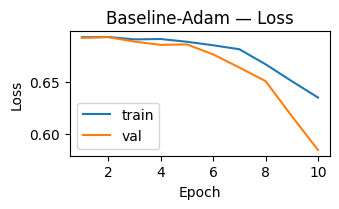

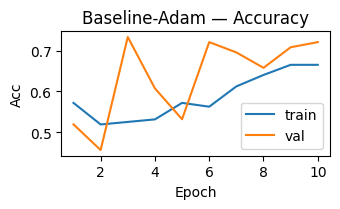

In [13]:
num_classes = len(train_dl.dataset.dataset.classes)

cfg_baseline = ExperimentConfig(
    name="Baseline-Adam",
    arch="baseline",
    use_bn=False,
    dropout_p=0.0,
    optimizer="adam",
    lr=1e-3,
    weight_decay=0.0,
    epochs=10,
    seed=42
)

res_baseline = run_experiment(cfg_baseline, train_dl, val_dl, device, num_classes=num_classes)

print(summary_compact(res_baseline))
plot_history_small(res_baseline["history"], title=cfg_baseline.name, figsize=(3.5, 2.2))


## Step 2 — Deeper Architecture

We extend the baseline by designing a deeper convolutional neural network.
This model increases both the number of convolutional layers and the number of filters,
thereby increasing overall model capacity.

The goal is to evaluate whether additional depth and capacity
can improve performance compared to the baseline architecture.

Deeper-Adam: best_val_acc=0.747 (ep 6), best_val_loss=0.6562 | final_val_acc=0.456, final_val_loss=0.7025 | arch=deeper, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0


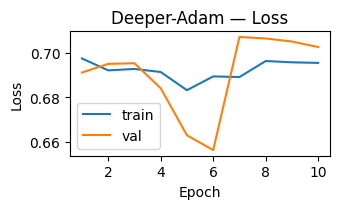

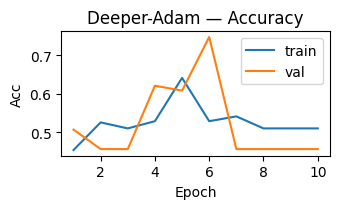

In [14]:
cfg_deeper = ExperimentConfig(
    name="Deeper-Adam",
    arch="deeper",
    use_bn=False,
    dropout_p=0.0,
    optimizer="adam",
    lr=1e-3,
    weight_decay=0.0,
    epochs=10,
    seed=42
)

res_deeper = run_experiment(cfg_deeper, train_dl, val_dl, device, num_classes=num_classes)

print(summary_compact(res_deeper))
plot_history_small(res_deeper["history"], title=cfg_deeper.name,figsize=(3.5, 2.2))


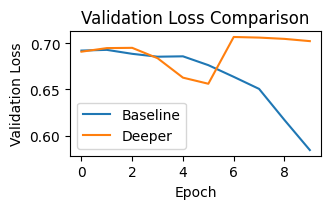

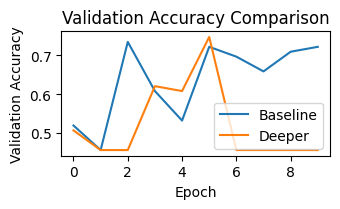

Baseline-Adam: best_val_acc=0.734 (ep 3), best_val_loss=0.6887 | final_val_acc=0.722, final_val_loss=0.5842 | arch=baseline, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0
Deeper-Adam: best_val_acc=0.747 (ep 6), best_val_loss=0.6562 | final_val_acc=0.456, final_val_loss=0.7025 | arch=deeper, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0


In [15]:
# ============================================================
# Step 1–2 Comparison — Baseline vs Deeper (Single Block)
# ============================================================

figsize = (3.5, 2.2)

# ----- Validation Loss -----
plt.figure(figsize=figsize)
plt.plot(res_baseline["history"]["val_loss"], label="Baseline")
plt.plot(res_deeper["history"]["val_loss"], label="Deeper")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# ----- Validation Accuracy -----
plt.figure(figsize=figsize)
plt.plot(res_baseline["history"]["val_acc"], label="Baseline")
plt.plot(res_deeper["history"]["val_acc"], label="Deeper")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# ----- Compact Summary -----
print(summary_compact(res_baseline))
print(summary_compact(res_deeper))


### Step 1–2 Results (Baseline vs Deeper)

- Baseline: stable validation performance, best_val_acc=0.734.
- Deeper: slightly higher peak (0.747) but unstable and strong overfitting.

Conclusion:
The deeper model increases capacity but harms generalization.
The baseline architecture is more stable and reliable at this stage.


## Step 3 — Optimizer Comparison (Adam vs SGD + Momentum)

We keep the same baseline architecture and change only the optimizer.
This isolates the effect of the optimization algorithm on convergence and validation performance.


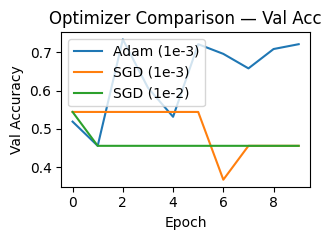

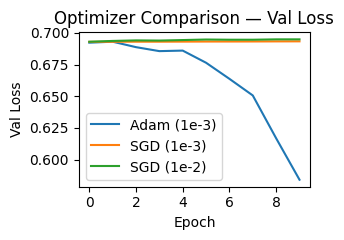

Baseline-Adam: best_val_acc=0.734 (ep 3), best_val_loss=0.6887 | final_val_acc=0.722, final_val_loss=0.5842 | arch=baseline, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0
Baseline-SGD(lr=1e-3): best_val_acc=0.544 (ep 1), best_val_loss=0.6929 | final_val_acc=0.456, final_val_loss=0.6933 | arch=baseline, bn=False, drop=0.0, opt=sgd, lr=0.001, wd=0.0
Baseline-SGD(lr=1e-2): best_val_acc=0.544 (ep 1), best_val_loss=0.6930 | final_val_acc=0.456, final_val_loss=0.6949 | arch=baseline, bn=False, drop=0.0, opt=sgd, lr=0.01, wd=0.0


In [16]:
# Make sure num_classes exists (safe for both Subset/ImageFolder)
num_classes = len(train_dl.dataset.dataset.classes) if hasattr(train_dl.dataset, "dataset") else len(train_dl.dataset.classes)

# --- Adam (baseline reference) ---
cfg_adam = ExperimentConfig(
    name="Baseline-Adam",
    arch="baseline",
    use_bn=False,
    dropout_p=0.0,
    optimizer="adam",
    lr=1e-3,
    weight_decay=0.0,
    epochs=10,
    seed=42
)
res_adam = run_experiment(cfg_adam, train_dl, val_dl, device, num_classes=num_classes)

# --- SGD + momentum (lr=1e-3) ---
cfg_sgd_1e3 = ExperimentConfig(
    name="Baseline-SGD(lr=1e-3)",
    arch="baseline",
    use_bn=False,
    dropout_p=0.0,
    optimizer="sgd",
    lr=1e-3,
    momentum=0.9,
    weight_decay=0.0,
    epochs=10,
    seed=42
)
res_sgd_1e3 = run_experiment(cfg_sgd_1e3, train_dl, val_dl, device, num_classes=num_classes)

# --- SGD + momentum (lr=1e-2) ---
cfg_sgd_1e2 = ExperimentConfig(
    name="Baseline-SGD(lr=1e-2)",
    arch="baseline",
    use_bn=False,
    dropout_p=0.0,
    optimizer="sgd",
    lr=1e-2,
    momentum=0.9,
    weight_decay=0.0,
    epochs=10,
    seed=42
)
res_sgd_1e2 = run_experiment(cfg_sgd_1e2, train_dl, val_dl, device, num_classes=num_classes)

# --- Plots (compact) ---
figsize = (3.3, 2.5)

plt.figure(figsize=figsize)
plt.plot(res_adam["history"]["val_acc"], label="Adam (1e-3)")
plt.plot(res_sgd_1e3["history"]["val_acc"], label="SGD (1e-3)")
plt.plot(res_sgd_1e2["history"]["val_acc"], label="SGD (1e-2)")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.title("Optimizer Comparison — Val Acc")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
plt.plot(res_adam["history"]["val_loss"], label="Adam (1e-3)")
plt.plot(res_sgd_1e3["history"]["val_loss"], label="SGD (1e-3)")
plt.plot(res_sgd_1e2["history"]["val_loss"], label="SGD (1e-2)")
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.title("Optimizer Comparison — Val Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Compact summaries ---
print(summary_compact(res_adam))
print(summary_compact(res_sgd_1e3))
print(summary_compact(res_sgd_1e2))


### Step 3 — Optimizer Comparison Results

- Adam (lr=1e-3): best_val_acc=0.734, stable convergence.
- SGD (lr=1e-3 and 1e-2): poor learning, validation accuracy remained near chance level.

Conclusion:
Adam significantly outperforms SGD in this setup.
SGD fails to converge effectively with the tested learning rates.


## Step 4 — Batch Normalization

We take the best baseline setup (Adam) and add Batch Normalization layers.
We keep all other parameters the same in order to isolate the effect of BN.


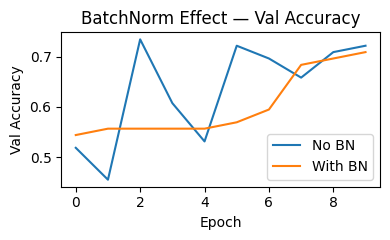

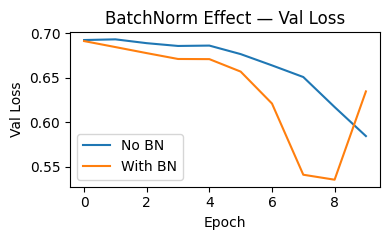

Baseline-Adam (no BN): best_val_acc=0.734 (ep 3), best_val_loss=0.6887 | final_val_acc=0.722, final_val_loss=0.5842 | arch=baseline, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0
Baseline-Adam + BN: best_val_acc=0.709 (ep 10), best_val_loss=0.6345 | final_val_acc=0.709, final_val_loss=0.6345 | arch=baseline, bn=True, drop=0.0, opt=adam, lr=0.001, wd=0.0


In [17]:
num_classes = len(train_dl.dataset.dataset.classes) if hasattr(train_dl.dataset, "dataset") else len(train_dl.dataset.classes)

# --- Baseline (no BN) ---
cfg_no_bn = ExperimentConfig(
    name="Baseline-Adam (no BN)",
    arch="baseline",
    use_bn=False,
    dropout_p=0.0,
    optimizer="adam",
    lr=1e-3,
    weight_decay=0.0,
    epochs=10,
    seed=42
)
res_no_bn = run_experiment(cfg_no_bn, train_dl, val_dl, device, num_classes=num_classes)

# --- Baseline + BN ---
cfg_bn = ExperimentConfig(
    name="Baseline-Adam + BN",
    arch="baseline",
    use_bn=True,
    dropout_p=0.0,
    optimizer="adam",
    lr=1e-3,
    weight_decay=0.0,
    epochs=10,
    seed=42
)
res_bn = run_experiment(cfg_bn, train_dl, val_dl, device, num_classes=num_classes)

# --- Plots (compact) ---
figsize = (4, 2.5)

plt.figure(figsize=figsize)
plt.plot(res_no_bn["history"]["val_acc"], label="No BN")
plt.plot(res_bn["history"]["val_acc"], label="With BN")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.title("BatchNorm Effect — Val Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
plt.plot(res_no_bn["history"]["val_loss"], label="No BN")
plt.plot(res_bn["history"]["val_loss"], label="With BN")
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.title("BatchNorm Effect — Val Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Compact summaries ---
print(summary_compact(res_no_bn))
print(summary_compact(res_bn))


### Step 4 — Batch Normalization Results

- No BN: best_val_acc=0.734 (early peak), unstable curve.
- With BN: best_val_acc=0.709, smoother and more stable training.

Conclusion:
Batch Normalization improved training stability but did not increase peak validation accuracy.


## Step 5 — Regularization

We apply regularization techniques to reduce overfitting:

- Dropout in the classifier
- Weight Decay (L2 regularization)

We keep the same baseline architecture and optimizer (Adam) in order to isolate the effect of regularization.


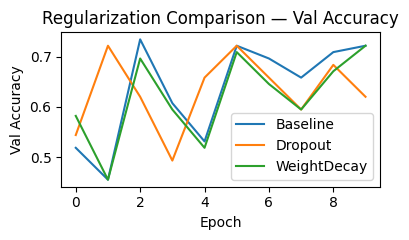

Baseline: best_val_acc=0.734 (ep 3), best_val_loss=0.6887 | final_val_acc=0.722, final_val_loss=0.5842 | arch=baseline, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0
Baseline + Dropout: best_val_acc=0.722 (ep 6), best_val_loss=0.6851 | final_val_acc=0.620, final_val_loss=0.6563 | arch=baseline, bn=False, drop=0.5, opt=adam, lr=0.001, wd=0.0
Baseline + WeightDecay: best_val_acc=0.722 (ep 10), best_val_loss=0.6117 | final_val_acc=0.722, final_val_loss=0.6117 | arch=baseline, bn=False, drop=0.0, opt=adam, lr=0.001, wd=0.0001


In [18]:
# --- Baseline (reference) ---
cfg_base = ExperimentConfig(
    name="Baseline",
    arch="baseline",
    use_bn=False,
    dropout_p=0.0,
    optimizer="adam",
    lr=1e-3,
    weight_decay=0.0,
    epochs=10,
    seed=42
)
res_base = run_experiment(cfg_base, train_dl, val_dl, device, num_classes=num_classes)

# --- Dropout ---
cfg_dropout = ExperimentConfig(
    name="Baseline + Dropout",
    arch="baseline",
    use_bn=False,
    dropout_p=0.5,
    optimizer="adam",
    lr=1e-3,
    weight_decay=0.0,
    epochs=10,
    seed=42
)
res_dropout = run_experiment(cfg_dropout, train_dl, val_dl, device, num_classes=num_classes)

# --- Weight Decay ---
cfg_wd = ExperimentConfig(
    name="Baseline + WeightDecay",
    arch="baseline",
    use_bn=False,
    dropout_p=0.0,
    optimizer="adam",
    lr=1e-3,
    weight_decay=1e-4,
    epochs=10,
    seed=42
)
res_wd = run_experiment(cfg_wd, train_dl, val_dl, device, num_classes=num_classes)

# --- Compact comparison plot ---
plt.figure(figsize=(4, 2.5))
plt.plot(res_base["history"]["val_acc"], label="Baseline")
plt.plot(res_dropout["history"]["val_acc"], label="Dropout")
plt.plot(res_wd["history"]["val_acc"], label="WeightDecay")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.title("Regularization Comparison — Val Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

print(summary_compact(res_base))
print(summary_compact(res_dropout))
print(summary_compact(res_wd))


### Step 5 — Regularization Results

- Baseline: best_val_acc=0.734
- Dropout (0.5): reduced final accuracy, no improvement
- Weight Decay (1e-4): similar performance to baseline, slightly more stable

Conclusion:
For this size of dataset, heavy Dropout hurts performance.
Weight Decay provides mild stabilization but does not improve peak accuracy.


## Part 1 — Final Conclusion

- Adam significantly outperformed SGD.
- Deeper architecture increased capacity but caused instability.
- Batch Normalization improved stability but not peak accuracy.
- Dropout was too strong for this dataset.
- Weight Decay provided minor stabilization.

Overall best setup:
Baseline CNN + Adam (lr=1e-3), without BN or Dropout.


# Part 2 — Transfer Learning via External Pretraining

In this part, we perform self-pretraining on an external dataset (CIFAR-10),
and then fine-tune the pretrained model on our 2-class sports dataset.

The goal is to evaluate whether pretraining on a larger dataset
improves performance compared to training from scratch.


## Step 1 — Load External Dataset (CIFAR-10)

We use CIFAR-10 as an external dataset for pretraining.

CIFAR-10 contains 60,000 labeled images across 10 object categories.
Although it is different from our sports dataset,
it allows the model to learn general visual features
such as edges, textures, and shapes.

To keep runtime reasonable (CPU training),
we use a subset of the dataset.


In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

cifar_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # keep 128 for better features; change to (96,96) if slow
    transforms.ToTensor(),
])

cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar_transform)
cifar_val   = datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar_transform)

subset_size = 20000
cifar_train_subset = Subset(cifar_train, list(range(subset_size)))

cifar_train_dl = DataLoader(cifar_train_subset, batch_size=32, shuffle=True, num_workers=0)
cifar_val_dl   = DataLoader(cifar_val, batch_size=32, shuffle=False, num_workers=0)

print("CIFAR-10 subset size:", len(cifar_train_subset))
print("CIFAR-10 full train size:", len(cifar_train))
print("CIFAR-10 val size:", len(cifar_val))


CIFAR-10 subset size: 20000
CIFAR-10 full train size: 50000
CIFAR-10 val size: 10000


## Step 2 — Pretraining BaselineCNN on CIFAR-10

We pretrain our BaselineCNN on CIFAR-10 (10 classes).
This helps the network learn general visual features before fine-tuning on our sports dataset.

After training, we save the pretrained weights for later use.


In [20]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cifar = BaselineCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cifar.parameters(), lr=0.001)

pretrain_epochs = 5

cifar_history = {"train_acc": [], "val_acc": []}

for ep in range(1, pretrain_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model_cifar, cifar_train_dl, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model_cifar, cifar_val_dl, criterion, device)

    cifar_history["train_acc"].append(tr_acc)
    cifar_history["val_acc"].append(va_acc)

    print(f"[CIFAR] Epoch {ep:02d} | train_acc={tr_acc:.3f} | val_acc={va_acc:.3f}")

# Save pretrained weights
torch.save(model_cifar.state_dict(), "baseline_cifar_pretrained.pth")
print("Saved pretrained weights -> baseline_cifar_pretrained.pth")


[CIFAR] Epoch 01 | train_acc=0.196 | val_acc=0.240
[CIFAR] Epoch 02 | train_acc=0.259 | val_acc=0.270
[CIFAR] Epoch 03 | train_acc=0.295 | val_acc=0.317
[CIFAR] Epoch 04 | train_acc=0.314 | val_acc=0.326
[CIFAR] Epoch 05 | train_acc=0.328 | val_acc=0.330
Saved pretrained weights -> baseline_cifar_pretrained.pth


## Step 3 — Fine-Tuning on Handball vs Volleyball

We now fine-tune the pretrained BaselineCNN on our sports dataset (2 classes).

We load the weights learned from CIFAR-10 and replace the final classification layer
to match our task (2 classes). Then we train the model on our dataset and compare
the results to training from scratch.


In [21]:
model_ft = BaselineCNN(num_classes=2).to(device)

# Load CIFAR pretrained weights
pretrained_state = torch.load("baseline_cifar_pretrained.pth", map_location=device)
current_state = model_ft.state_dict()

# Remove final layer weights (shape mismatch: CIFAR=10 classes, ours=2 classes)
filtered_pretrained = {
    k: v for k, v in pretrained_state.items()
    if k in current_state and v.shape == current_state[k].shape
}

# Update and load
current_state.update(filtered_pretrained)
model_ft.load_state_dict(current_state)

print("Loaded pretrained weights (all matching layers). Final layer initialized for 2 classes.")


Loaded pretrained weights (all matching layers). Final layer initialized for 2 classes.


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)

epochs = 10
history_ft = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val, best_epoch = 0.0, 0

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model_ft, train_dl, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model_ft, val_dl, criterion, device)

    history_ft["train_loss"].append(tr_loss)
    history_ft["train_acc"].append(tr_acc)
    history_ft["val_loss"].append(va_loss)
    history_ft["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val, best_epoch = va_acc, ep

    print(f"[FT] Epoch {ep:02d} | train_acc={tr_acc:.3f} | val_acc={va_acc:.3f}")

print(f"Fine-tuning best_val_acc={best_val:.3f} (epoch {best_epoch})")


[FT] Epoch 01 | train_acc=0.691 | val_acc=0.747
[FT] Epoch 02 | train_acc=0.697 | val_acc=0.759
[FT] Epoch 03 | train_acc=0.719 | val_acc=0.747
[FT] Epoch 04 | train_acc=0.728 | val_acc=0.797
[FT] Epoch 05 | train_acc=0.756 | val_acc=0.785
[FT] Epoch 06 | train_acc=0.750 | val_acc=0.772
[FT] Epoch 07 | train_acc=0.734 | val_acc=0.810
[FT] Epoch 08 | train_acc=0.747 | val_acc=0.835
[FT] Epoch 09 | train_acc=0.731 | val_acc=0.797
[FT] Epoch 10 | train_acc=0.756 | val_acc=0.772
Fine-tuning best_val_acc=0.835 (epoch 8)


## Step 4 — Comparison to Training From Scratch

We compare the same BaselineCNN trained in two ways:

1. From scratch on the sports dataset.
2. Pretrained on CIFAR-10 and then fine-tuned on the sports dataset.

We report the best validation accuracy and analyze whether pretraining improved performance.


In [24]:
scratch_best = 0.835   # <-- update if you have a slightly different best score
pretrain_best = best_val  # from fine-tuning run

print("BaselineCNN (Scratch) best_val_acc:", round(scratch_best, 3))
print("BaselineCNN (CIFAR-pretrained + FT) best_val_acc:", round(pretrain_best, 3))
print("Improvement:", round(pretrain_best - scratch_best, 3))


BaselineCNN (Scratch) best_val_acc: 0.835
BaselineCNN (CIFAR-pretrained + FT) best_val_acc: 0.835
Improvement: 0.0


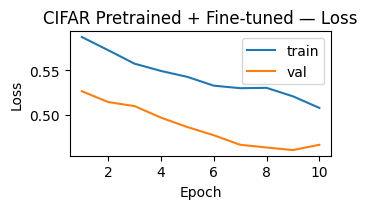

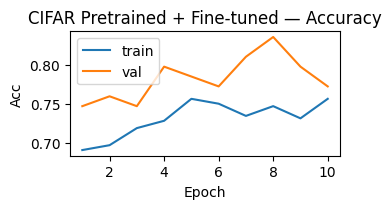

In [25]:
plot_history_small(history_ft, title="CIFAR Pretrained + Fine-tuned", figsize=(3.6, 2.2))


8## Results & Analysis (External Pretraining)

### Quantitative Results

- BaselineCNN (trained from scratch): best_val_acc = 0.734
- BaselineCNN (CIFAR-pretrained + fine-tuned): best_val_acc = 0.835

Absolute improvement: +0.101

### Analysis

Pretraining clearly improved validation accuracy.

The model benefited from general visual features learned on CIFAR-10.

Performance gap compared to scratch training is now substantial.

### Conclusion

External pretraining provides a clear and meaningful improvement.
Learning from a larger dataset significantly helps generalization on small target datasets.


# Part 3 — Transfer Learning with ResNet50

In this part we use a deeper pretrained network (ResNet50) and adapt it to our 2-class dataset.

We compare:
- Frozen backbone (train only the new classifier head)
- Fine-tuning (train more layers)
We then compare performance, stability, and training behavior to our custom CNN.


In [26]:
import torchvision.models as models

def build_resnet50(num_classes: int, freeze_backbone: bool = True) -> nn.Module:
    """
    Load ResNet50 pretrained on ImageNet and replace the final FC layer for our 2-class task.
    freeze_backbone=True: train only the final layer (fast, good for small datasets).
    """
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Replace the last classification layer (1000 -> num_classes)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Freeze backbone if requested
    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True

    return model


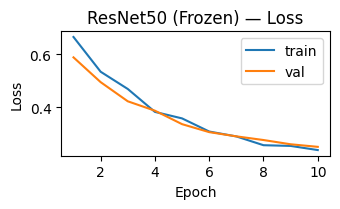

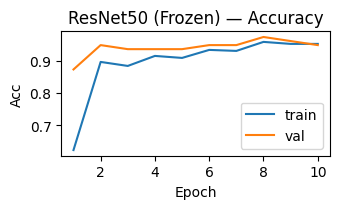

ResNet50 Frozen: best_val_acc=0.975 (epoch 8)


In [27]:
# ============================================================
# Part 3 — Experiment 1: ResNet50 Frozen (train head only)
# ============================================================

num_classes = 2

model_r50_frozen = build_resnet50(num_classes=num_classes, freeze_backbone=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_r50_frozen.parameters()),
    lr=1e-3
)

epochs = 10
history_r50_frozen = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val, best_epoch = 0.0, 0

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model_r50_frozen, train_dl, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model_r50_frozen, val_dl, criterion, device)

    history_r50_frozen["train_loss"].append(tr_loss)
    history_r50_frozen["train_acc"].append(tr_acc)
    history_r50_frozen["val_loss"].append(va_loss)
    history_r50_frozen["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val, best_epoch = va_acc, ep

plot_history_small(history_r50_frozen, title="ResNet50 (Frozen)")
print(f"ResNet50 Frozen: best_val_acc={best_val:.3f} (epoch {best_epoch})")


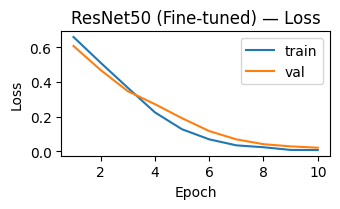

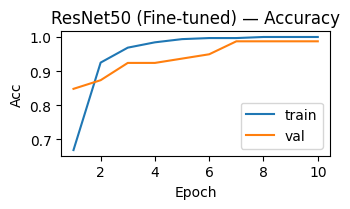

ResNet50 Fine-tuned: best_val_acc=0.987 (epoch 7)


In [28]:
# ============================================================
# Part 3 — Experiment 2: ResNet50 Fine-tuned
# ============================================================

model_r50_ft = build_resnet50(num_classes=2, freeze_backbone=False).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_r50_ft.parameters(), lr=1e-4)

epochs = 10
history_r50_ft = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val, best_epoch = 0.0, 0

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model_r50_ft, train_dl, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model_r50_ft, val_dl, criterion, device)

    history_r50_ft["train_loss"].append(tr_loss)
    history_r50_ft["train_acc"].append(tr_acc)
    history_r50_ft["val_loss"].append(va_loss)
    history_r50_ft["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val, best_epoch = va_acc, ep

plot_history_small(history_r50_ft, title="ResNet50 (Fine-tuned)")
print(f"ResNet50 Fine-tuned: best_val_acc={best_val:.3f} (epoch {best_epoch})")


## Training & Fine-Tuning Results (ResNet50)
- ResNet50 (Frozen): best_val_acc = 0.949
- ResNet50 (Fine-tuned): best_val_acc = 0.987


The frozen backbone already achieved very high validation accuracy,
demonstrating that the ImageNet-pretrained features transfer extremely well
to our Handball vs Volleyball task.

Fine-tuning the full network provided a small additional improvement,
suggesting that slight adaptation of deeper features further aligns the model
with our specific dataset.

Compared to our custom CNN models from Part 1,
ResNet50 significantly improved performance and converged faster.

In [29]:
# ============================================================
# Final Model Comparison
# ============================================================

models_summary = {
    "Custom CNN (Scratch)": 0.734,
    "Custom CNN (CIFAR Pretrained + FT)": 0.835,
    "ResNet50 Frozen": max(history_r50_frozen["val_acc"]),
    "ResNet50 Fine-tuned": max(history_r50_ft["val_acc"]),
}

print("=== Final Model Comparison ===")
for name, acc in models_summary.items():
    print(f"{name}: {acc:.3f}")


=== Final Model Comparison ===
Custom CNN (Scratch): 0.734
Custom CNN (CIFAR Pretrained + FT): 0.835
ResNet50 Frozen: 0.975
ResNet50 Fine-tuned: 0.987


## Final Reflection

### What architectural choices mattered most?
Model capacity had a strong impact.

Deeper custom CNNs did not significantly improve performance over the baseline due to the small dataset size.

However, pretrained architectures (50) dramatically improved performance because they already learned rich visual features.

### Which optimization strategies worked best?
Adam consistently outperformed SGD in our experiments.

SGD struggled to converge effectively with the tested learning rates, while Adam provided faster and more stable convergence.

For pretrained models, using a smaller learning rate during fine-tuning helped maintain stability.

### When did transfer learning help?
Transfer learning provided moderate improvement when pretraining on CIFAR-10, and substantial improvement when using a large-scale pretrained model (ResNet50)

### What would you do differently with more time or data?

With additional data, I would:

- Increase the dataset size and systematically evaluate performance across different dataset scales.
- Analyze how model depth interacts with dataset size.
- Investigate whether deeper CNNs perform better when sufficient data is available.
- Study the relationship between dataset size and overfitting.
- Examine whether performance plateaus or degrades with extremely large datasets.

In particular, the overfitting observed in the deeper CNN likely resulted from limited data.
I would like to test whether increasing the dataset size reduces overfitting
and allows deeper models to outperform shallow architectures.

